In [3]:
import numpy as np
import pandas as pd
import uproot
import xgboost as xgb
import matplotlib.pyplot as plt
from xgbo import XgboRegressor
import os
from scipy.stats import norm
import matplotlib.mlab as mlab




In [4]:
def load_data(file_name, entrystop, isEE=False):

    root_file = uproot.open(file_name)

    # The branches we need for the regression
    branches_EB = [ 'clusterRawEnergy', 'full5x5_e3x3', 'full5x5_eMax',
            'full5x5_e2nd', 'full5x5_eTop', 'full5x5_eBottom', 'full5x5_eLeft',
            'full5x5_eRight', 'full5x5_e2x5Max', 'full5x5_e2x5Top',
            'full5x5_e2x5Bottom', 'full5x5_e2x5Left', 'full5x5_e2x5Right',
            'full5x5_e5x5', 'rawEnergy', 'etaWidth', 'phiWidth', 'rhoValue',
            'full5x5_sigmaIetaIeta', 'full5x5_sigmaIetaIphi',
            'full5x5_sigmaIphiIphi', 'iEtaSeed', 'iPhiSeed', 'iEtaMod5',
            'iPhiMod2', 'iEtaMod20', 'iPhiMod20', 'genEnergy']

    branches_EE = [ 'clusterRawEnergy', 'full5x5_e3x3', 'full5x5_eMax',
            'full5x5_e2nd', 'full5x5_eTop', 'full5x5_eBottom', 'full5x5_eLeft',
            'full5x5_eRight', 'full5x5_e2x5Max', 'full5x5_e2x5Top',
            'full5x5_e2x5Bottom', 'full5x5_e2x5Left', 'full5x5_e2x5Right',
            'full5x5_e5x5', 'rawEnergy', 'etaWidth', 'phiWidth', 'rhoValue',
            'full5x5_sigmaIetaIeta', 'full5x5_sigmaIetaIphi',
            'full5x5_sigmaIphiIphi',
            'genEnergy', 'iXSeed', 'iYSeed', 'preshowerEnergy']

    if isEE:
        branches = branches_EE + ["pt", "eta"]
    else:
        branches = branches_EB + ["pt", "eta"]

    if "Electron" in file_name:
        df = root_file['een_analyzer/ElectronTree'].pandas.df(branches, entrystop=entrystop).dropna()
    if "Photon" in file_name:
        df = root_file['een_analyzer/PhotonTree'].pandas.df(branches, entrystop=entrystop).dropna()
    print("Entries in ntuple:")
    print(len(df))
    print(df.shape)


    df.eval("clusertRawEnergyOverE5x5 = clusterRawEnergy/full5x5_e5x5", inplace=True)
    df.eval("w3x3OverE5x5             = full5x5_e3x3/full5x5_e5x5", inplace=True)
    df.eval("eMaxOverE5x5             = full5x5_eMax/full5x5_e5x5", inplace=True)
    df.eval("e2ndOverE5x5             = full5x5_e2nd/full5x5_e5x5", inplace=True)
    df.eval("eTopOverE5x5             = full5x5_eTop/full5x5_e5x5", inplace=True)
    df.eval("eBottomOverE5x5          = full5x5_eBottom/full5x5_e5x5", inplace=True)
    df.eval("eLeftOverE5x5            = full5x5_eLeft/full5x5_e5x5", inplace=True)
    df.eval("eRightOverE5x5           = full5x5_eRight/full5x5_e5x5", inplace=True)
    df.eval("e2x5MaxOverE5x5          = full5x5_e2x5Max/full5x5_e5x5", inplace=True)
    df.eval("e2x5TopOverE5x5          = full5x5_e2x5Top/full5x5_e5x5", inplace=True)
    df.eval("e2x5BottomOverE5x5       = full5x5_e2x5Bottom/full5x5_e5x5", inplace=True)
    df.eval("e2x5LeftOverE5x5         = full5x5_e2x5Left/full5x5_e5x5", inplace=True)
    df.eval("e2x5RightOverE5x5        = full5x5_e2x5Right/full5x5_e5x5", inplace=True)

    if isEE:
        df.eval("preshowerEnergyOverrawEnergy = preshowerEnergy/rawEnergy", inplace=True)

    # The target
    if isEE:
        df.eval("target = ( rawEnergy + preshowerEnergy )/genEnergy", inplace=True)
    else:
        df.eval("target = rawEnergy/genEnergy", inplace=True)

    return df


In [5]:
# The features
features_EB = [ 'rawEnergy', 'etaWidth', 'phiWidth', 'rhoValue',
        'full5x5_sigmaIetaIeta', 'full5x5_sigmaIetaIphi',
        'full5x5_sigmaIphiIphi', 'clusertRawEnergyOverE5x5', 'w3x3OverE5x5',
        'eMaxOverE5x5', 'e2ndOverE5x5', 'eTopOverE5x5', 'eBottomOverE5x5',
        'eLeftOverE5x5', 'eRightOverE5x5', 'e2x5MaxOverE5x5',
        'e2x5TopOverE5x5', 'e2x5BottomOverE5x5', 'e2x5LeftOverE5x5',
        'e2x5RightOverE5x5', 'iEtaSeed', 'iPhiSeed', 'iEtaMod5', 'iPhiMod2',
        'iEtaMod20', 'iPhiMod20','pt','eta','target']

# EE
features_EE = [ 'rawEnergy', 'etaWidth', 'phiWidth', 'rhoValue',
        'full5x5_sigmaIetaIeta', 'full5x5_sigmaIetaIphi',
        'full5x5_sigmaIphiIphi', 'clusertRawEnergyOverE5x5', 'w3x3OverE5x5',
        'eMaxOverE5x5', 'e2ndOverE5x5', 'eTopOverE5x5', 'eBottomOverE5x5',
        'eLeftOverE5x5', 'eRightOverE5x5', 'e2x5MaxOverE5x5',
        'e2x5TopOverE5x5', 'e2x5BottomOverE5x5', 'e2x5LeftOverE5x5',
        'e2x5RightOverE5x5', 'iXSeed', 'iYSeed', 'preshowerEnergyOverrawEnergy','pt','eta','target']


file_name = "/scratch/micheli/Electron/perfectIC-lowpt-EB-training.root"


isEE = '-EE-' in file_name

if isEE:
    features = features_EE
else:
    features = features_EB
DF= load_data(file_name, entrystop=1500000,isEE=isEE)


Entries in ntuple:
3428975
(3428975, 30)


In [6]:

DF=DF.query('pt>20')

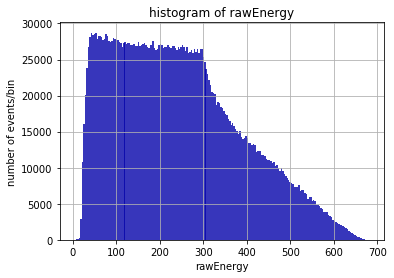

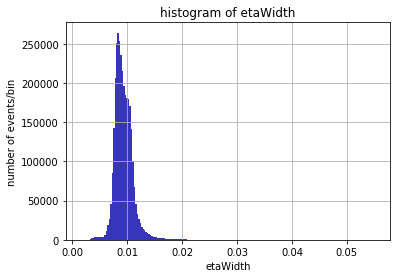

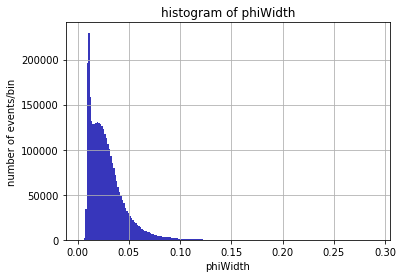

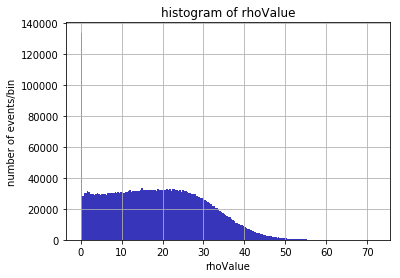

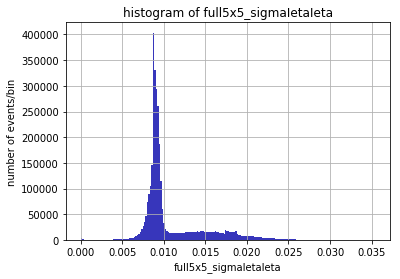

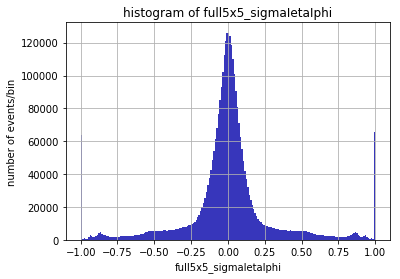

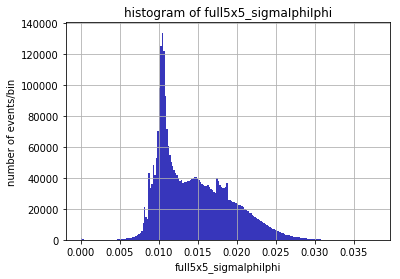

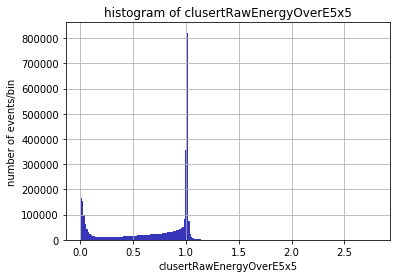

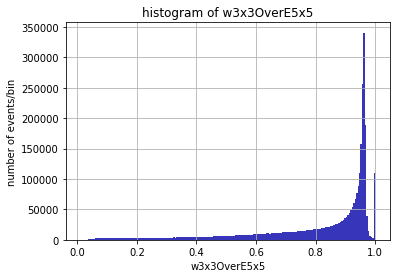

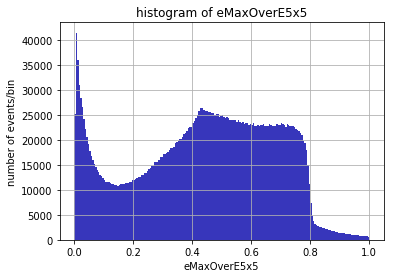

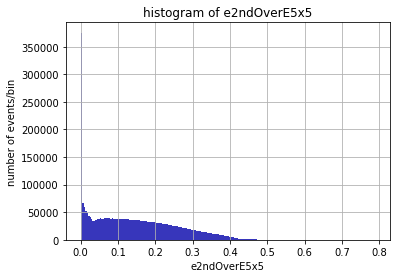

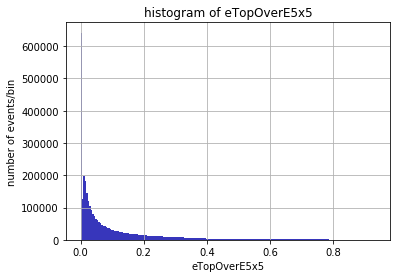

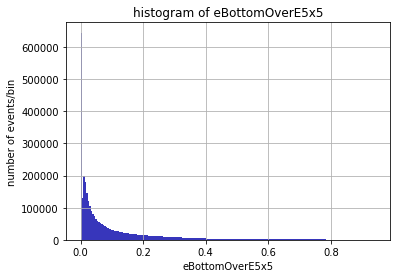

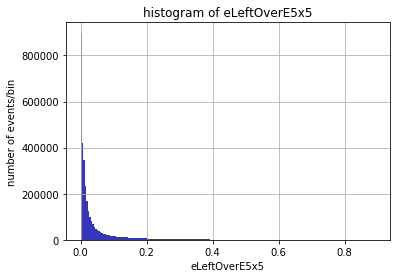

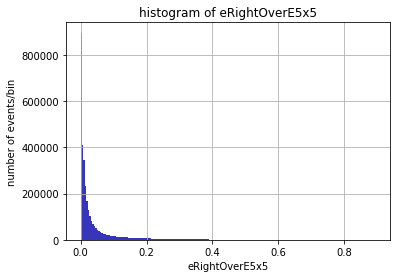

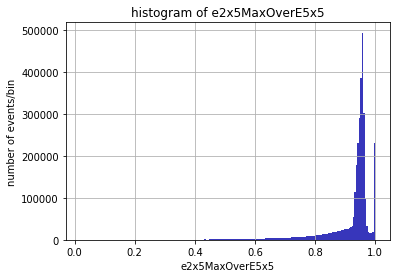

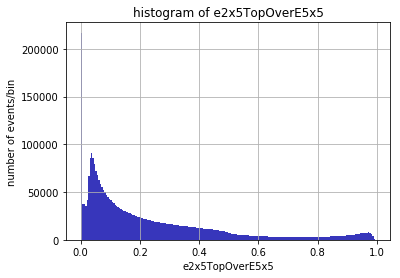

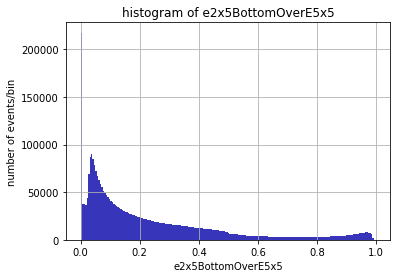

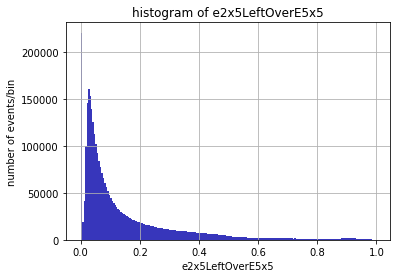

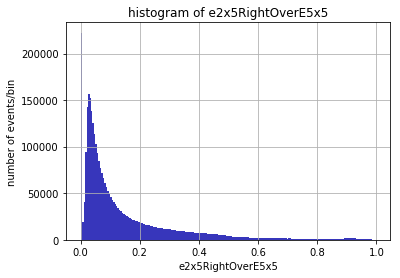

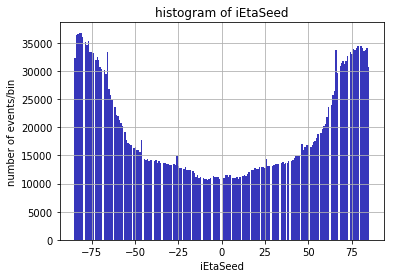

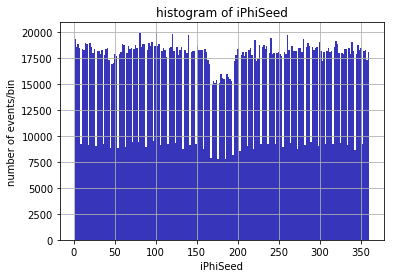

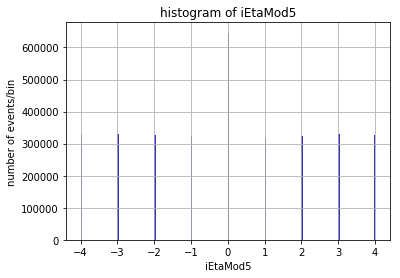

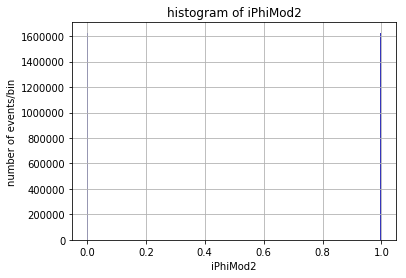

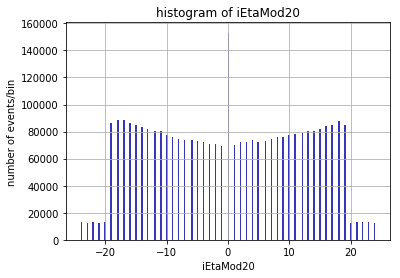

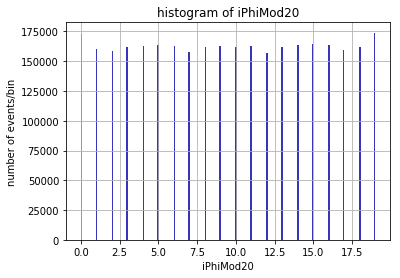

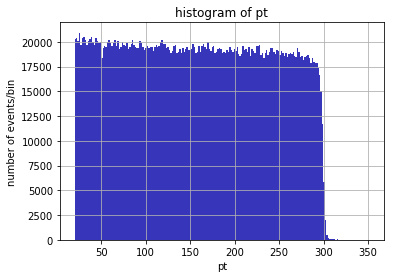

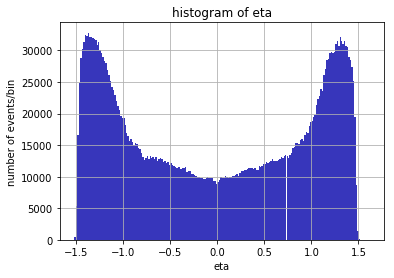

In [9]:
k=0
for para in features:
    #(mu, sigma) = norm.fit(DF[para])
    if para =='target':
        pass
    else:
        weights = np.ones_like(DF[para])/float(len(DF[para]))
        n, bins, patches = plt.hist(x=DF[para], bins=200,weights=None,alpha=0.8, color='#0504aa',density=0)
        plt.title('histogram of '+para)
        plt.xlabel(para)
        plt.ylabel('number of events/bin')
    #y = mlab.normpdf( bins, mu, sigma)
    #l = plt.plot(bins, y, 'r--', linewidth=2)
        plt.grid()
        plt.gcf().subplots_adjust(left=0.15)
        plt.savefig('hist_'+str(k)+'.png')

        plt.show()
        k+=1

<function matplotlib.pyplot.show>

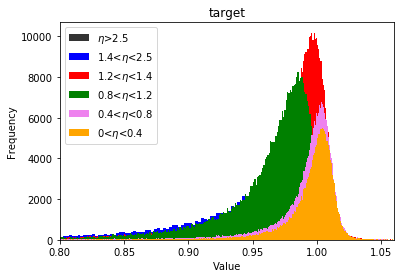

In [14]:
DF_endcap=DF.query('eta>2.5')
DF_endbarrell=DF.query('1.2<eta<1.4')
DF1=DF.query('0.8<eta<1.2')
DF0=DF.query('0.4<eta<0.8')
DF2=DF.query('0<eta<0.4')
DF3=DF.query('1.4<eta<2.5')
DF4=DF.query('eta<0')
plt.figure()
plt.title('target')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.hist(DF_endcap['target'],bins='auto',alpha=0.8,color='black',density=0,label='$\eta$>2.5')
plt.hist(DF3['target'],bins='auto',color='blue',label='1.4<$\eta$<2.5')
plt.hist(DF1['target'],bins='auto',color='red',label='1.2<$\eta$<1.4')
plt.hist(DF_endbarrell['target'],bins='auto',color='green',label='0.8<$\eta$<1.2')
plt.hist(DF0['target'],bins='auto',color='violet',label='0.4<$\eta$<0.8')

plt.hist(DF2['target'],bins='auto',color='orange',label='0<$\eta$<0.4')
#plt.hist(DF4['target'],bins='auto',color='yellow',label='$\eta$<0')
#plt.ylim([0,50])
plt.xlim([0.8,1.06])
plt.savefig('target.png')
plt.legend()
plt.show

eta>2.5
2<eta<2.5
1.2<eta<1.4
0.8<eta<1.2
0.4<eta<0.8
0<eta<0.4
eta<0


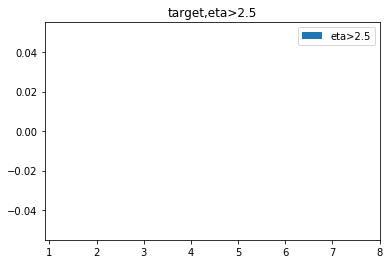

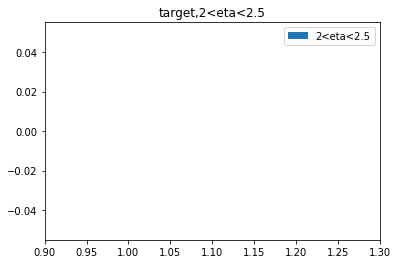

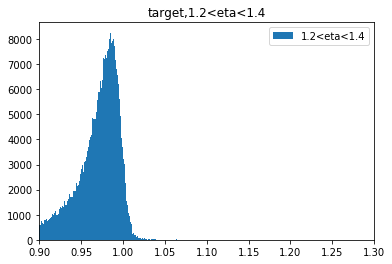

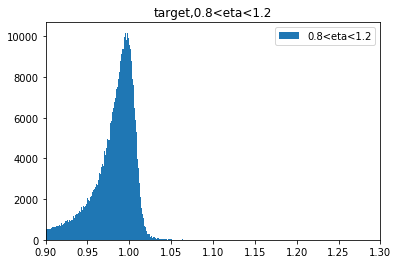

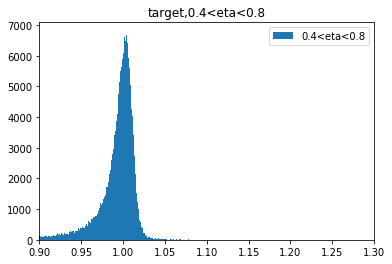

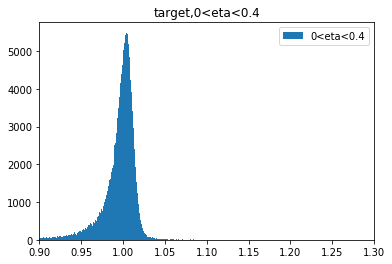

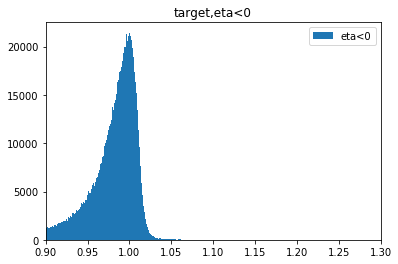

In [9]:
feat_etabin=['eta>2.5','2<eta<2.5','1.2<eta<1.4','0.8<eta<1.2','0.4<eta<0.8','0<eta<0.4','eta<0']
i=0
#DF_etabin=pd.DataFrame(data=[DF.query('eta>2.5'),DF.query('1.4<eta<2.5'),DF.query('1.2<eta<1.4'),DF.query('0.8<eta<1.2'),DF.query('0.4<eta<0.8'),DF.query('0<eta<0.4')],columns=[feat_etabin])
for para in feat_etabin:
    if i==0:
        j=8
    else:
        j=1.3
    print(para)
    plt.figure()
    df=DF.query(para)
    plt.hist(df['target'],bins='auto',label=para)
    #plt.ylim([0,500])
    plt.title('target,'+para)
    plt.xlim([0.9,j])
    plt.savefig('target_'+para+'.png')
    plt.legend()
    plt.show
    i+=1

/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:33: LogWarning: x is really small return 0
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:33: SmallIntegralWarning: (-0.5, 0.01, 12.0, 3.8, 1.0, -0.998)


RuntimeError: exception was raised in user function
User function arguments:
     alpha = +0.004001
    alpha2 = +0.020868
         n = +8.123321
        n2 = +11.473441
      mean = +1.004642
     sigma = +0.000113


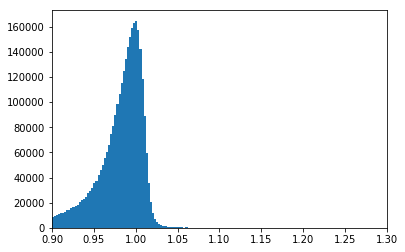

In [10]:
rmin = 0.8
rmax = 1.6
nbins = 100

data=np.array(DF.query('target<1.3')['target']).astype('double')
plt.figure()
plt.hist(data,bins=500)
plt.xlim([0.9,1.3])
#plt.show()
# Fit a DCB
bound_DCB=[rmin, rmax]
normalized_DCB = probfit.Normalized(probfit.pdf.doublecrystalball, bound_DCB)
binned_likelihood   = probfit.BinnedLH(normalized_DCB, data, bins=500, bound=bound_DCB)

#best_try = probfit.try_uml(binned_likelihood, data, alpha=0.1,alpha2=0.3, n=2.1,n2=5, mean=1.2, sigma=0.03)
#print(best_try)
pars_dcb = dict(mean  = 1., 
                fix_mean = False,
                sigma  = 0.002,
                fix_sigma = False,
                alpha  = -0.5,
                fix_alpha = False,
                n      = 12.0,
                fix_n  = False,
                alpha2 = 0.01,
                fix_alpha2 = False,
                n2     = 3.8,
                fix_n2  = False
                )


minuit = iminuit.Minuit(binned_likelihood,print_level=3, **pars_dcb)
minuit.migrad()

binned_likelihood.draw(minuit)
plt.legend(loc='upper right')
plt.show()
plt.savefig('target_all_eta_fit'+'.png')
print(minuit)

In [ ]:
n=16
eta=np.zeros((n))
mean=np.zeros((n))
err_mean=np.zeros((n))
sigma=np.zeros((n))
err_sigma=np.zeros((n))
print(mean)
feat=[]
for i in range (n):
    a=1.4-0.2*i
    b=a+0.2
    eta[i]= (a+b)/2
    feat.append(str(a)+'<eta<'+str(b))
i=0
for para in feat:
    plt.figure()
    df=DF.query(para).astype('double')
    df=df.query('eta<1.4442')
    data=np.array(df.query('0.83<target<1.05')['target']).astype('double')
    nbins = 200
    #out=plt.hist(data,bins=nbins,label=para,density=0)
    #plt.ylim([0,500])
    
    #surface_hist=sum(out[0][:]*np.diff(out[1][:]))
    print(i)
    plt.title('target,'+para)
    plt.xlim([0.8,1.1])
    
    plt.legend()
    
    rmin = 0.83
    rmax = 1.05
    df=DF.query(para).astype('double')
    
    bound_DCB=[rmin, rmax]
    normalized_DCB = probfit.Normalized(probfit.pdf.doublecrystalball, bound_DCB)
    binned_likelihood = probfit.BinnedLH(normalized_DCB, data, bins=nbins,use_w2=False, bound=bound_DCB)
   
   
    for j in range(2):
        #first step
        
        
        if j==0 and (i==8 or i==7): 
            pars_dcb = dict(mean  = 0.97, 
                        fix_mean = False,
                        sigma  = 0.01,
                        fix_sigma = False,
                        alpha  = 1,
                        fix_alpha = False,
                        n      = 6,
                        fix_n  = False,
                        alpha2 =1,
                        fix_alpha2 = False,
                        n2     = 4,
                        fix_n2  = False
        
                           )
        elif j==0 and (i!=8 and i!=7):
            pars_dcb = dict(mean  = 0.99, 
                        fix_mean = False,
                        sigma  = 0.01,
                        fix_sigma = False,
                        alpha  = 1,
                        fix_alpha = False,
                        n      = 6,
                        fix_n  = False,
                        alpha2 =1,
                        fix_alpha2 = False,
                        n2     = 4,
                        fix_n2  = False
        
                           )
        #optimize parameter withoptimized start parameter
        elif j==1 and i==0:
            pars_dcb=dict(mean  = minuit.values['mean'], 
                        fix_mean = False,
                        sigma  = minuit.values['sigma'],
                        fix_sigma = False,
                        alpha  = minuit.values['alpha'],
                        fix_alpha = False,
                        n      = minuit.values['n'],
                        fix_n  = False,
                        alpha2 = minuit.values['alpha2'],
                        fix_alpha2 = False,
                        n2     = minuit.values['n2'],
                        fix_n2  = False
                        )
        else:
            pars_dcb=dict(mean  = minuit.values['mean'], 
                        fix_mean = False,
                        sigma  = minuit.values['sigma'],
                        fix_sigma = False,
                        alpha  = minuit.values['alpha'],
                        fix_alpha = False,
                        n      = minuit.values['n'],
                        fix_n  = True,
                        alpha2 = minuit.values['alpha2'],
                        fix_alpha2 = True,
                        n2     = minuit.values['n2'],
                        fix_n2  =False
                        )
    
        minuit = iminuit.Minuit(binned_likelihood,print_level=3, **pars_dcb)
        minuit.migrad() #optimized parameter
     
    
    #normalized_plot_range = probfit.Normalized(probfit.pdf.doublecrystalball, plot_range)
    #binned_likelihood_plot_range = probfit.BinnedLH(normalized_plot_range, data, bins=nbins, bound=plot_range)
    #binned_likelihood_plot_range.draw(minuit,nfbins=nbins,parmloc=(0.5,0.75))
    
    binned_likelihood.draw(minuit,nfbins=nbins, parmloc=(0.5,0.75))
    
    print(para)
    mean[i]=minuit.values['mean']
    sigma[i]=minuit.values['sigma']
    err_mean[i]=minuit.errors['mean']
    err_sigma[i]=minuit.errors['sigma']
    i+=1
    plt.savefig('target_'+para+'_fit'+'.png')
    plt.show()
print(mean)
print(sigma)
Sigma=sigma

In [ ]:
para='-0.2<eta<0'
i=9
plt.figure()
    
df=DF.query(para).astype('double')
rmin = 0.85
rmax = 1.05
data=np.array(df.query('0.85<target<1.05')['target']).astype('double')
nbins = 250
#out=plt.hist(data,bins=nbins,label=para,density=0,range=[rmin,rmax])
plt.title(para)
    
    
plt.legend()
       
bound_DCB=[rmin, rmax]
normalized_DCB = probfit.Normalized(probfit.pdf.doublecrystalball, bound_DCB)
binned_likelihood = probfit.BinnedLH(normalized_DCB, data, bins=nbins,use_w2=False, bound=bound_DCB)
   
for j in range(4):
    if j==0:
           
        pars_dcb = dict(mean  =0.98, 
                        fix_mean = False,
                        sigma  = 0.01,
                        fix_sigma = False,
                        alpha  =1,
                        fix_alpha = False,
                        n      = 4,
                        fix_n  = False,
                        alpha2 =1,
                        fix_alpha2 = False,
                        n2     = 3,
                        fix_n2  = False
        
                           )
    else:
        pars_dcb=dict(mean  = minuit.values['mean'], 
                        fix_mean = False,
                        sigma  = minuit.values['sigma'],
                        fix_sigma = False,
                        alpha  = minuit.values['alpha'],
                        fix_alpha = False,
                        n      = minuit.values['n'],
                        fix_n  = False,
                        alpha2 = minuit.values['alpha2'],
                        fix_alpha2 = False,
                        n2     = minuit.values['n2'],
                        fix_n2  = False
                        )
    minuit = iminuit.Minuit(binned_likelihood,print_level=3, **pars_dcb)
    minuit.migrad() #optimized parameter
print(para)
binned_likelihood.draw(minuit,nfbins=nbins, parmloc=(0.5,0.75))
mean[i]=minuit.values['mean']
sigma[i]=minuit.values['sigma']
err_mean[i]=minuit.errors['mean']
err_sigma[i]=minuit.errors['sigma']
print(i)

plt.savefig('target_'+para+'_fit'+'_pt'+'.png')
    
plt.show()

In [ ]:
Sigma=sigma
print(Sigma)
X=np.atleast_2d(eta).T
y=mean
x = np.atleast_2d(np.linspace(-1.5, 1.5, 1000)).T

# Instantiate a Gaussian Process model
kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)

# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(X, y)

# Make the prediction on the meshed x-axis (ask for MSE as well)
y_pred, sig = gp.predict(x, return_std=True)

# Plot the function, the prediction and the 95% confidence interval based on
# the MSE
plt.figure()

plt.errorbar(eta,mean, yerr=err_mean, fmt='r.',label='data',ecolor='black',capsize=1)
#plt.plot(x, y_pred, 'b-', label=u'Prediction')
#plt.fill(np.concatenate([x, x[::-1]]),
#         np.concatenate([y_pred - 1.9600 * sig,
#                        (y_pred + 1.9600 * sig)[::-1]]),
 #        alpha=.5, fc='b', ec='None', label='95% confidence interval')



plt.title('mean against eta')
#plt.xlabel('$\eta$')
plt.legend()
plt.savefig('mean_against_eta'+'.png')
plt.grid()
plt.show()

Xs=np.atleast_2d(eta).T
ys=Sigma
x = np.atleast_2d(np.linspace(-1.5, 1.5, 1000)).T

# Instantiate a Gaussian Process model
kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)

# Fit to data using Maximum Likelihood Estimation of the parameters
print(Sigma,eta)
gp.fit(Xs, ys)

# Make the prediction on the meshed x-axis (ask for MSE as well)
y_pred, sig= gp.predict(x, return_std=True)

# Plot the function, the prediction and the 95% confidence interval based on
# the MSE
plt.figure()

plt.errorbar(eta,sigma,yerr=err_sigma,fmt='r.',label='data',ecolor='black',capsize=1)
#plt.plot(x, y_pred, 'b-', label=u'Prediction')
#plt.fill(np.concatenate([x, x[::-1]]),
 #        np.concatenate([y_pred - 1.9600 * sig,
  #                      (y_pred + 1.9600 * sig)[::-1]]),
   #      alpha=.5, fc='b', ec='None', label='95% confidence interval')


plt.xlabel=('$\eta$')
plt.ylabel=('standart deviation of the energy')
plt.title('sigma against eta')
plt.savefig('sigma_against_eta'+'.png')
plt.grid()
plt.legend()
plt.show()

In [ ]:
n=29
pt=np.zeros((n))
mean_pt=np.zeros((n))
err_mean_pt=np.zeros((n))
sigma_pt=np.zeros((n))
err_sigma_pt=np.zeros((n))

feat_pt=[]
for i in range (n):
    a=300-10*i
    b=a+10
    pt[i]= (a+b)/2
    feat_pt.append(str(a)+'<pt<'+str(b))
i=0

for para in feat_pt:
    plt.figure()
    df=DF.query(para).astype('double')
    rmin = 0.94
    rmax = 1.035

    data=np.array(df.query('0.94<target<1.035')['target']).astype('double')
    nbins = 170
    #out=plt.hist(data,bins=nbins,label=para,density=0,range=[rmin,rmax])
    plt.title(para)
    
    
    plt.legend()
    
    
    
    bound_DCB=[rmin, rmax]
    normalized_DCB_pt = probfit.Normalized(probfit.pdf.doublecrystalball, bound_DCB)
    binned_likelihood_pt = probfit.BinnedLH(normalized_DCB_pt, data, bins=nbins,use_w2=False, bound=bound_DCB)
   
   
    for j in range(4):
        if j==0:
            if i==18:
                a=0.99
            if i<15:
                a=1.002
            elif i==0:
                a=1
            else:
                a=0.9998
            pars_dcb = dict(mean  =a , 
                        fix_mean = False,
                        sigma  = 0.001,
                        fix_sigma = False,
                        alpha  = 1,
                        fix_alpha = False,
                        n      = 20,
                        fix_n  = False,
                        alpha2 =1,
                        fix_alpha2 = False,
                        n2     = 60,
                        fix_n2  = False
        
                           )
        elif j==1:
            
              pars_dcb=dict(mean  = minuit_pt.values['mean'], 
                        fix_mean = False,
                        sigma  = minuit_pt.values['sigma'],
                        fix_sigma = False,
                        alpha  = minuit_pt.values['alpha'],
                        fix_alpha = False,
                        n      = minuit_pt.values['n'],
                        fix_n  = False,
                        alpha2 = minuit_pt.values['alpha2'],
                        fix_alpha2 = False,
                        n2     = minuit_pt.values['n2'],
                        fix_n2  = False
                        )
        elif j==2:
            pars_dcb=dict(mean  = minuit_pt.values['mean'], 
                        fix_mean = False,
                        sigma  = minuit_pt.values['sigma'],
                        fix_sigma = False,
                        alpha  = minuit_pt.values['alpha'],
                        fix_alpha = False,
                        n      = minuit_pt.values['n'],
                        fix_n  = False,
                        alpha2 = minuit_pt.values['alpha2'],
                        fix_alpha2 = False,
                        n2     = minuit_pt.values['n2'],
                        fix_n2  = False
                        )
        elif j==3:
            pars_dcb=dict(mean  = minuit_pt.values['mean'], 
                        fix_mean = False,
                        sigma  = minuit_pt.values['sigma'],
                        fix_sigma = False,
                        alpha  = minuit_pt.values['alpha'],
                        fix_alpha = False,
                        n      = minuit_pt.values['n'],
                        fix_n  = False,
                        alpha2 = minuit_pt.values['alpha2'],
                        fix_alpha2 = False,
                        n2     = minuit_pt.values['n2'],
                        fix_n2  = False
                        )
        minuit_pt = iminuit.Minuit(binned_likelihood_pt,print_level=3, **pars_dcb)
        minuit_pt.migrad() #optimized parameter
        if j==2 and i!=18:
            j+=1
    binned_likelihood_pt.draw(minuit_pt,nfbins=nbins, parmloc=(0.5,0.75))
    
    print(para)
    mean_pt[i]=minuit_pt.values['mean']
    sigma_pt[i]=minuit_pt.values['sigma']
    err_mean_pt[i]=minuit_pt.errors['mean']
    err_sigma_pt[i]=minuit_pt.errors['sigma']
    print(i)
    i+=1
    plt.savefig('target_'+para+'_fit'+'_pt'+'.png')
    
    plt.show()
print(mean_pt)
print(sigma_pt)

In [ ]:
para='290<pt<300'
i=1
plt.figure()
    
df=DF.query(para).astype('double')
 
rmin = 0.91
rmax = 1.06
data=np.array(df.query('0.91<target<1.06')['target']).astype('double')
nbins = 150
#out=plt.hist(data,bins=nbins,label=para,density=0,range=[rmin,rmax])
plt.title(para)
    
    
plt.legend()
    
rmin = 0.94
rmax = 1.09
df=DF.query(para).astype('double')
    
bound_DCB=[rmin, rmax]
normalized_DCB_pt = probfit.Normalized(probfit.pdf.doublecrystalball, bound_DCB)
binned_likelihood_pt = probfit.BinnedLH(normalized_DCB_pt, data, bins=nbins,use_w2=False, bound=bound_DCB)
   
for j in range(3):
    if j==0:
           
        pars_dcb = dict(mean  =1, 
                        fix_mean = False,
                        sigma  = 0.01,
                        fix_sigma = False,
                        alpha  = 1,
                        fix_alpha = False,
                        n      = 4,
                        fix_n  = False,
                        alpha2 =1,
                        fix_alpha2 = False,
                        n2     = 20,
                        fix_n2  = False
        
                           )
    else:
        pars_dcb=dict(mean  = minuit_pt.values['mean'], 
                        fix_mean = False,
                        sigma  = minuit_pt.values['sigma'],
                        fix_sigma = False,
                        alpha  = minuit_pt.values['alpha'],
                        fix_alpha = False,
                        n      = minuit_pt.values['n'],
                        fix_n  = False,
                        alpha2 = minuit_pt.values['alpha2'],
                        fix_alpha2 = False,
                        n2     = minuit_pt.values['n2'],
                        fix_n2  = False
                        )
    minuit_pt = iminuit.Minuit(binned_likelihood_pt,print_level=3, **pars_dcb)
    minuit_pt.migrad() #optimized parameter
print(para)
binned_likelihood_pt.draw(minuit_pt,nfbins=nbins, parmloc=(0.5,0.75))
''''mean_pt[i]=minuit_pt.values['mean']
sigma_pt[i]=minuit_pt.values['sigma']
err_mean_pt[i]=minuit_pt.errors['mean']
err_sigma_pt[i]=minuit_pt.errors['sigma']'''
print(i)
i+=1
plt.savefig('target_'+para+'_fit'+'_pt'+'.png')
    
plt.show()

In [ ]:
para='210<pt<220'
i=9
plt.figure()
    
df=DF.query(para).astype('double')
 
rmin = 0.91
rmax = 1.03
data=np.array(df.query('0.91<target<1.03')['target']).astype('double')
nbins = 150
#out=plt.hist(data,bins=nbins,label=para,density=0,range=[rmin,rmax])
plt.title(para)
    
    
plt.legend()
    

df=DF.query(para).astype('double')
    
bound_DCB=[rmin, rmax]
normalized_DCB_pt = probfit.Normalized(probfit.pdf.doublecrystalball, bound_DCB)
binned_likelihood_pt = probfit.BinnedLH(normalized_DCB_pt, data, bins=nbins,use_w2=False, bound=bound_DCB)
   
for j in range(3):
    if j==0:
           
        pars_dcb = dict(mean  =1, 
                        fix_mean = False,
                        sigma  = 0.01,
                        fix_sigma = False,
                        alpha  = 1,
                        fix_alpha = False,
                        n      = 4,
                        fix_n  = False,
                        alpha2 =1,
                        fix_alpha2 = False,
                        n2     = 20,
                        fix_n2  = False
        
                           )
    else:
        pars_dcb=dict(mean  = minuit_pt.values['mean'], 
                        fix_mean = False,
                        sigma  = minuit_pt.values['sigma'],
                        fix_sigma = False,
                        alpha  = minuit_pt.values['alpha'],
                        fix_alpha = False,
                        n      = minuit_pt.values['n'],
                        fix_n  = False,
                        alpha2 = minuit_pt.values['alpha2'],
                        fix_alpha2 = False,
                        n2     = minuit_pt.values['n2'],
                        fix_n2  = False
                        )
    minuit_pt = iminuit.Minuit(binned_likelihood_pt,print_level=3, **pars_dcb)
    minuit_pt.migrad() #optimized parameter
print(para)
binned_likelihood_pt.draw(minuit_pt,nfbins=nbins, parmloc=(0.5,0.75))
''''mean_pt[i]=minuit_pt.values['mean']
sigma_pt[i]=minuit_pt.values['sigma']
err_mean_pt[i]=minuit_pt.errors['mean']
err_sigma_pt[i]=minuit_pt.errors['sigma']'''
print(i)
i+=1
plt.savefig('target_'+para+'_fit'+'_pt'+'.png')
    
plt.show()

In [ ]:
para='220<pt<230'
i=8
plt.figure()
    
df=DF.query(para).astype('double')
rmin = 0.92
rmax = 1.04
data=np.array(df.query('0.92<target<1.04')['target']).astype('double')
nbins = 150
#out=plt.hist(data,bins=nbins,label=para,density=0,range=[rmin,rmax],color='')
plt.title(para)
    
    
plt.legend()
    


df=DF.query(para).astype('double')
    
bound_DCB=[rmin, rmax]
normalized_DCB_pt = probfit.Normalized(probfit.pdf.doublecrystalball, bound_DCB)
binned_likelihood_pt = probfit.BinnedLH(normalized_DCB_pt, data, bins=nbins,use_w2=False, bound=bound_DCB)
   
for j in range(3):
    if j==0:
           
        pars_dcb = dict(mean  =1, 
                        fix_mean = False,
                        sigma  = 0.01,
                        fix_sigma = False,
                        alpha  = 1,
                        fix_alpha = False,
                        n      = 4,
                        fix_n  = False,
                        alpha2 =1,
                        fix_alpha2 = False,
                        n2     = 20,
                        fix_n2  = False
        
                           )
    else:
        pars_dcb=dict(mean  = minuit_pt.values['mean'], 
                        fix_mean = False,
                        sigma  = minuit_pt.values['sigma'],
                        fix_sigma = False,
                        alpha  = minuit_pt.values['alpha'],
                        fix_alpha = False,
                        n      = minuit_pt.values['n'],
                        fix_n  = False,
                        alpha2 = minuit_pt.values['alpha2'],
                        fix_alpha2 = False,
                        n2     = minuit_pt.values['n2'],
                        fix_n2  = False
                        )
    minuit_pt = iminuit.Minuit(binned_likelihood_pt,print_level=3, **pars_dcb)
    minuit_pt.migrad() #optimized parameter
print(para)
binned_likelihood_pt.draw(minuit_pt,nfbins=nbins, parmloc=(0.5,0.75))
mean_pt[i]=minuit_pt.values['mean']
sigma_pt[i]=minuit_pt.values['sigma']
err_mean_pt[i]=minuit_pt.errors['mean']
err_sigma_pt[i]=minuit_pt.errors['sigma']
print(i)
i+=1
plt.savefig('target_'+para+'_fit'+'_pt'+'.png')
    
plt.show()

In [ ]:
para='100<pt<110'
i=20
plt.figure()
    
df=DF.query(para).astype('double')
 
rmin = 0.91
rmax = 1.06
data=np.array(df.query('0.91<target<1.06')['target']).astype('double')
nbins = 150
#out=plt.hist(data,bins=nbins,label=para,density=0,range=[rmin,rmax])
plt.title(para)
    
    
plt.legend()
    

df=DF.query(para).astype('double')
    
bound_DCB=[rmin, rmax]
normalized_DCB_pt = probfit.Normalized(probfit.pdf.doublecrystalball, bound_DCB)
binned_likelihood_pt = probfit.BinnedLH(normalized_DCB_pt, data, bins=nbins,use_w2=False, bound=bound_DCB)
   
for j in range(3):
    if j==0:
           
        pars_dcb = dict(mean  =1, 
                        fix_mean = False,
                        sigma  = 0.01,
                        fix_sigma = False,
                        alpha  = 1,
                        fix_alpha = False,
                        n      = 4,
                        fix_n  = False,
                        alpha2 =1,
                        fix_alpha2 = False,
                        n2     = 20,
                        fix_n2  = False
        
                           )
    else:
        pars_dcb=dict(mean  = minuit_pt.values['mean'], 
                        fix_mean = False,
                        sigma  = minuit_pt.values['sigma'],
                        fix_sigma = False,
                        alpha  = minuit_pt.values['alpha'],
                        fix_alpha = False,
                        n      = minuit_pt.values['n'],
                        fix_n  = False,
                        alpha2 = minuit_pt.values['alpha2'],
                        fix_alpha2 = False,
                        n2     = minuit_pt.values['n2'],
                        fix_n2  = False
                        )
    minuit_pt = iminuit.Minuit(binned_likelihood_pt,print_level=3, **pars_dcb)
    minuit_pt.migrad() #optimized parameter
print(para)
binned_likelihood_pt.draw(minuit_pt,nfbins=nbins, parmloc=(0.5,0.75))
''''mean_pt[i]=minuit_pt.values['mean']
sigma_pt[i]=minuit_pt.values['sigma']
err_mean_pt[i]=minuit_pt.errors['mean']
err_sigma_pt[i]=minuit_pt.errors['sigma']'''
print(i)
i+=1
plt.savefig('target_'+para+'_fit'+'_pt'+'.png')
    
plt.show()

In [ ]:
   
X=np.atleast_2d(pt).T
y=mean_pt
x = np.atleast_2d(np.linspace(20, 320, 1000)).T

# Instantiate a Gaussian Process model
kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)

# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(X, y)

# Make the prediction on the meshed x-axis (ask for MSE as well)
y_pred, sig = gp.predict(x, return_std=True)

# Plot the function, the prediction and the 95% confidence interval based on
# the MSE
plt.figure()

plt.errorbar(pt,mean_pt, yerr=err_mean_pt, fmt='r.',label='data',ecolor='black',capsize=1)
#plt.plot(x, y_pred, 'b-', label=u'Prediction')
#plt.fill(np.concatenate([x, x[::-1]]),
 #        np.concatenate([y_pred - 1.9600 * sig,
 #                       (y_pred + 1.9600 * sig)[::-1]]),
   #      alpha=.5, fc='b', ec='None', label='95% confidence interval')
   

plt.title('mean against pt')
#plt.xlabel('$\eta$')
plt.legend()

plt.grid()
plt.ylim(0.98,1.03)
plt.savefig('mean_against_pt'+'.png')
plt.show()

Xs=np.atleast_2d(pt).T
ys=sigma_pt
x = np.atleast_2d(np.linspace(20, 300, 1000)).T

# Instantiate a Gaussian Process model
kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)

# Fit to data using Maximum Likelihood Estimation of the parameters

gp.fit(Xs, ys)

# Make the prediction on the meshed x-axis (ask for MSE as well)
y_pred, sig= gp.predict(x, return_std=True)

# Plot the function, the prediction and the 95% confidence interval based on
# the MSE
plt.figure()

plt.errorbar(pt,sigma_pt,yerr=err_sigma_pt,fmt='r.',label='data',ecolor='black',capsize=1)
#plt.plot(x, y_pred, 'b-', label=u'Prediction')
#plt.fill(np.concatenate([x, x[::-1]]),
         #np.concatenate([y_pred - 1.9600 * sig,
         #               (y_pred + 1.9600 * sig)[::-1]]),
         #alpha=.5, fc='b', ec='None', label='95% confidence interval')

plt.ylim(0.005,0.0175)

#plt.ylabel('$\sigma$')
plt.title('sigma against pt')
plt.savefig('sigma_against_pt'+'.png')
plt.grid()
plt.legend()
plt.show()